In [9]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import jax
import jax.numpy as jnp
a = jnp.ones((16,256,256,3))
del a # To prevent tensorflow from using GPU
import jax.lax as lax

import optax as opt
import numpy as np

from tqdm import tqdm

from functools import partial
from typing import Optional, Sequence, Any

import tensorflow as tf
import tensorflow_datasets as tfds
tf.config.set_visible_devices([], 'GPU')

import matplotlib.pyplot as plt

Pytree = Any

In [10]:
@jax.jit
def p_theta(z: jnp.ndarray, theta: Pytree) -> jnp.ndarray:
    """
    Generate x from z.
    Z is q_phi(z|x) when train, but since there's KL between q_phi(z|x) and p_theta(z) in loss function,
    we can use prior p(z) to generate x when inference.
    """
    for w, b in theta[:-1]:
        z = z @ w + b
        z = jax.nn.relu(z)
        
    w, b = theta[-1]
    z = z @ w + b
    return jnp.reshape(z, (-1, 28, 28, 1))


@jax.jit
def q_phi(x: jnp.ndarray, phi: Pytree) -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Generate z from x.
    Approximate true posterior p(z|x) with q_phi(z|x).
    """
    x  = jnp.reshape(x, (-1, 28 * 28))
    
    for w, b in phi[:-1]:
        x = x @ w + b
        x = jax.nn.relu(x)
    
    mu_w, mu_b, logvar_w, logvar_b = phi[-1]
    mu = x @ mu_w + mu_b
    logvar = x @ logvar_w + logvar_b

    return mu, logvar


@jax.jit
def reparametrize(mu: jnp.ndarray, logvar: jnp.ndarray, rng: jax.random.PRNGKey) -> jnp.ndarray:
    """
    Reparametrize trick.
    Replace z ~ N(mu, sigma) with z = mu + sigma * eps, eps ~ N(0, 1).
    """
    eps = jax.random.normal(rng, shape=mu.shape)
    return mu + jnp.exp(.5 * logvar) * eps


@jax.jit
def vae(
    x: jnp.ndarray, params: Pytree, rng: jax.random.PRNGKey
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    VAE model
    """
    params_q_phi, params_p_theta = params
    
    mu, logvar = q_phi(x, params_q_phi)
    z = reparametrize(mu, logvar, rng)
    x_hat = p_theta(z, params_p_theta)
    
    return x_hat, mu, logvar


@jax.jit
def sample(z: jnp.ndarray, params: Pytree) -> jnp.ndarray:
    """
    Generate x from z.
    """
    phi, theta = params
    return p_theta(z, theta)

In [11]:
@jax.jit
def reconstruction_loss(x: jnp.ndarray, x_hat: jnp.ndarray) -> jnp.ndarray:
    """
    This equals negative log-likelihood of x_hat given x.
    """
    log_p = jax.nn.sigmoid(x_hat)
    neg_log_p = jax.nn.sigmoid(-x_hat)
    return -jnp.mean(x * jnp.log(log_p) + (1 - x) * jnp.log(neg_log_p)) * 1000.

@jax.jit
def kl_divergence_analytic(mu: jnp.ndarray, logvar: jnp.ndarray) -> jnp.ndarray:
    """
    This equals KL term in -ELBO.
    """
    return jnp.mean(
        -0.5 * jnp.sum(1. + logvar - mu**2 - jnp.exp(logvar), axis=-1)
    ) 

In [12]:
def train_step(
    batch: jnp.ndarray, params: Pytree, rng: jax.random.PRNGKey, optimizer: callable,
    opt_state: opt.OptState
) -> tuple[jnp.ndarray, Pytree, callable, opt.OptState]:
    """Perform a single training step."""
    def loss_fn(params: Pytree) -> jnp.ndarray:
        """Compute the loss of the model."""
        x_hat, mu, logvar = vae(batch, params, rng)
        reconstrution_loss = reconstruction_loss(batch, x_hat)
        regularization_loss = kl_divergence_analytic(mu, logvar)
        negative_ELBO = reconstrution_loss + regularization_loss # -ELBO = -E_{q_{\phi}(z|x)}[log(p_{\theta}(x|z))] + KL(q_{\phi}(z|x) || p(z))
        return negative_ELBO
    
    loss, grad = jax.value_and_grad(loss_fn, has_aux=False)(params)
    updates, new_opt_state = optimizer.update(grad, opt_state, params)
    new_params = opt.apply_updates(params, updates)
    
    return loss, new_params, optimizer, new_opt_state

def test_step(
    batch: jnp.ndarray, params: Pytree, rng: jax.random.PRNGKey
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    x_hat, mu, logvar = vae(batch, params, rng)
    reconstrution_loss = reconstruction_loss(batch, x_hat)
    regularization_loss = kl_divergence_analytic(mu, logvar)
    total_loss = reconstrution_loss + regularization_loss
    return total_loss, reconstrution_loss, regularization_loss


def visualize(z: jnp.ndarray, params: Pytree, e: int) -> None:
    x_hat = np.array(jax.nn.sigmoid(sample(z, params)))
    
    fig, axes = plt.subplots(10, 10, figsize=(11, 10))
    
    for i in range(100):
        axes[i // 10, i % 10].imshow(x_hat[i], cmap='gray')
        axes[i // 10, i % 10].axis('off')
    
    fig.suptitle(f'Epoch {e}')
    plt.show()

In [13]:
def return_params(input_dim: int, output_dim: int, rng: jax.random.PRNGKey) -> Pytree:
    w = jax.random.normal(rng, (input_dim, output_dim)) * .02
    b = jnp.zeros(output_dim,)
    return w, b

def get_q_phi_params(n_units: int, n_layers: int, n_latent_dim: int, rng: jax.random.PRNGKey) -> Pytree:
    input_dim = 784
    q_phi_params = []
    for _ in range(n_layers):
        rng, _ = jax.random.split(rng)
        w, b = return_params(input_dim, n_units, rng)
        q_phi_params.append((w, b))
        input_dim = n_units
    rng_mu, rng_sigma = jax.random.split(rng)
    mu_w, mu_b = return_params(input_dim, n_latent_dim, rng_mu)
    sigma_w, sigma_b = return_params(input_dim, n_latent_dim, rng_sigma)
    q_phi_params.append((mu_w, mu_b, sigma_w, sigma_b))
    rng_last = jax.random.split(rng)[0]
    return q_phi_params, rng_last

def get_p_theta_params(n_units: int, n_layers: int, n_latent_dim: int, rng: jax.random.PRNGKey) -> Pytree:
    input_dim = n_latent_dim
    p_theta_params = []
    for _ in range(n_layers):
        rng, _ = jax.random.split(rng)
        w, b = return_params(input_dim, n_units, rng)
        p_theta_params.append((w, b))
        input_dim = n_units
    rng_last = jax.random.split(rng)[0]
    w, b = return_params(input_dim, 784, rng_last)
    p_theta_params.append((w, b))
    return p_theta_params

def init_params(n_units: int, n_layers: int, n_latent_dim: int, rng: jax.random.PRNGKey) -> Pytree:
    q_phi_params, rng = get_q_phi_params(n_units, n_layers, n_latent_dim, rng)
    p_theta_params = get_p_theta_params(n_units, n_layers, n_latent_dim, rng)
    return q_phi_params, p_theta_params

In [14]:
batch_size = 128
epochs = 5

lr = 0.0001

z_dim = 10
n_units = 512
n_layers = 3

seed = 0
key = jax.random.PRNGKey(seed)
key, key_init = jax.random.split(key)
key, key_test = jax.random.split(key)

params = init_params(n_units, n_layers, z_dim, key_init)
optimizer = opt.adam(learning_rate=lr)
opt_state = optimizer.init(params)
fixed_noise = jax.random.normal(key_test, (100, z_dim))

In [15]:
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=False)
train_ds = train_ds.map(lambda x: tf.cast(x['image'], tf.float32) / 255.0).cache().shuffle(10000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x: tf.cast(x['image'], tf.float32) / 255.0).cache().batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

Epoch 1/5 Training ...: 100%|██████████| 468/468 [00:18<00:00, 25.73it/s, Loss: 255.2782926940918] 


Epoch 1/5 - Train Loss: 302.27325550307575


Epoch 1/5 Testing ...: 100%|██████████| 79/79 [00:01<00:00, 70.44it/s] 


Epoch 1/5 - Test Loss: 253.77830505371094, Recon: 251.56337361396115, KL: 2.214931655533706


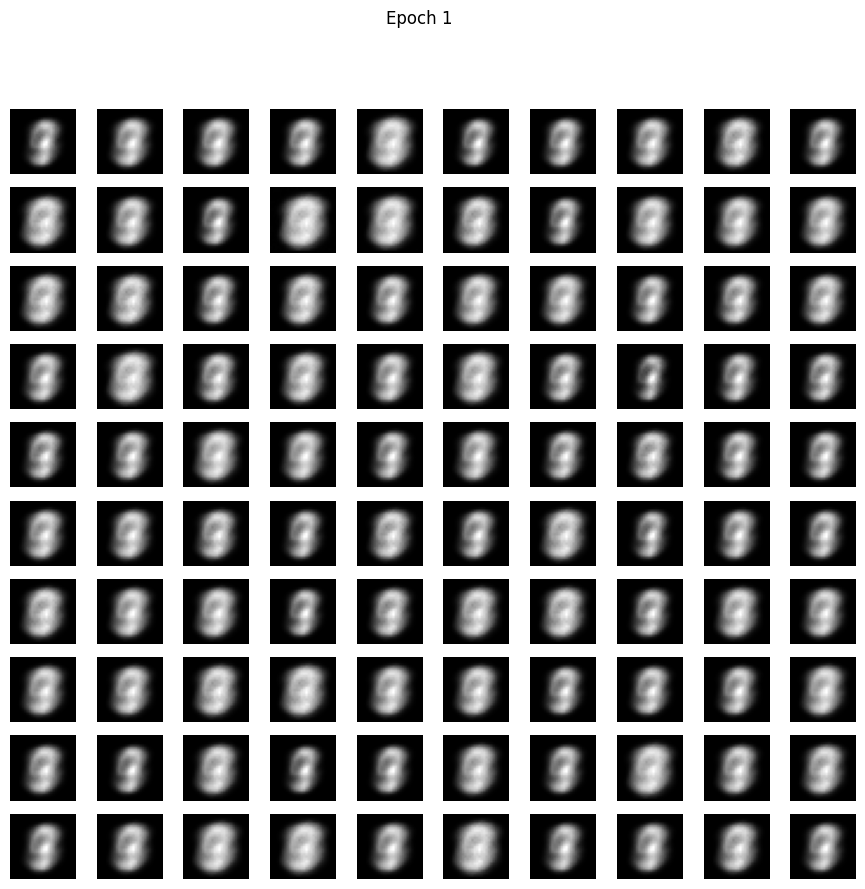

Epoch 2/5 Training ...: 100%|██████████| 468/468 [00:14<00:00, 31.80it/s, Loss: 243.0449247741699] 


Epoch 2/5 - Train Loss: 247.32099565685306


Epoch 2/5 Testing ...: 100%|██████████| 79/79 [00:00<00:00, 324.78it/s]


Epoch 2/5 - Test Loss: 241.90131445776058, Recon: 238.13686341877226, KL: 3.764450127565408


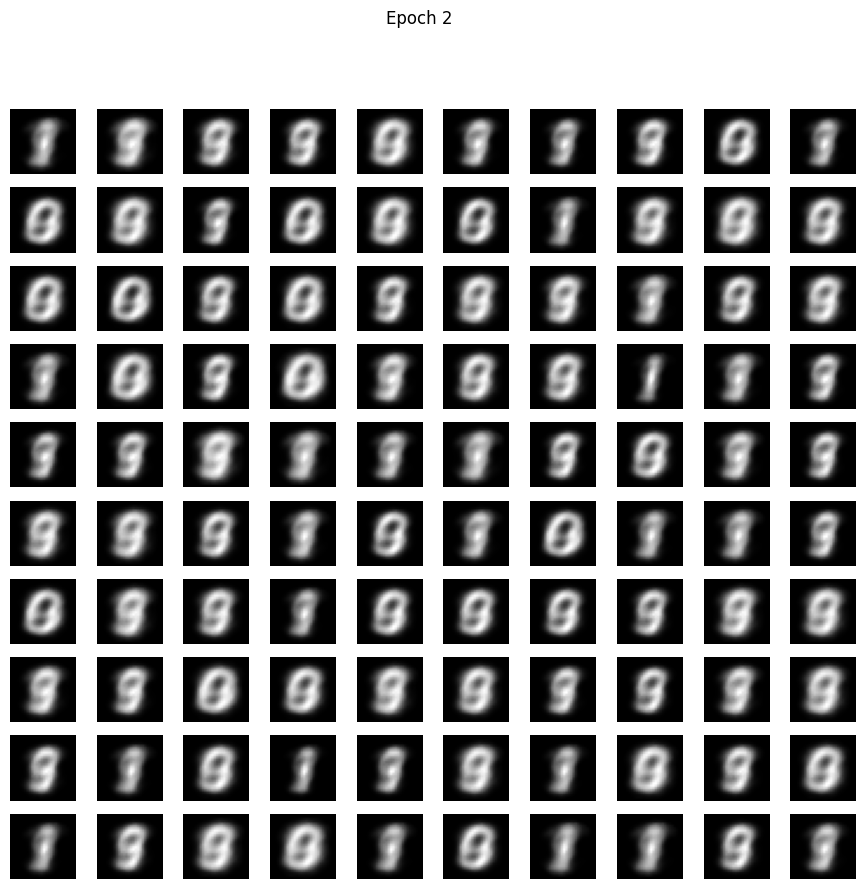

Epoch 3/5 Training ...: 100%|██████████| 468/468 [00:14<00:00, 31.37it/s, Loss: 234.39669525146485]


Epoch 3/5 - Train Loss: 238.39719756036743


Epoch 3/5 Testing ...: 100%|██████████| 79/79 [00:00<00:00, 338.10it/s]


Epoch 3/5 - Test Loss: 232.2624869044823, Recon: 227.999972959108, KL: 4.26251417172106


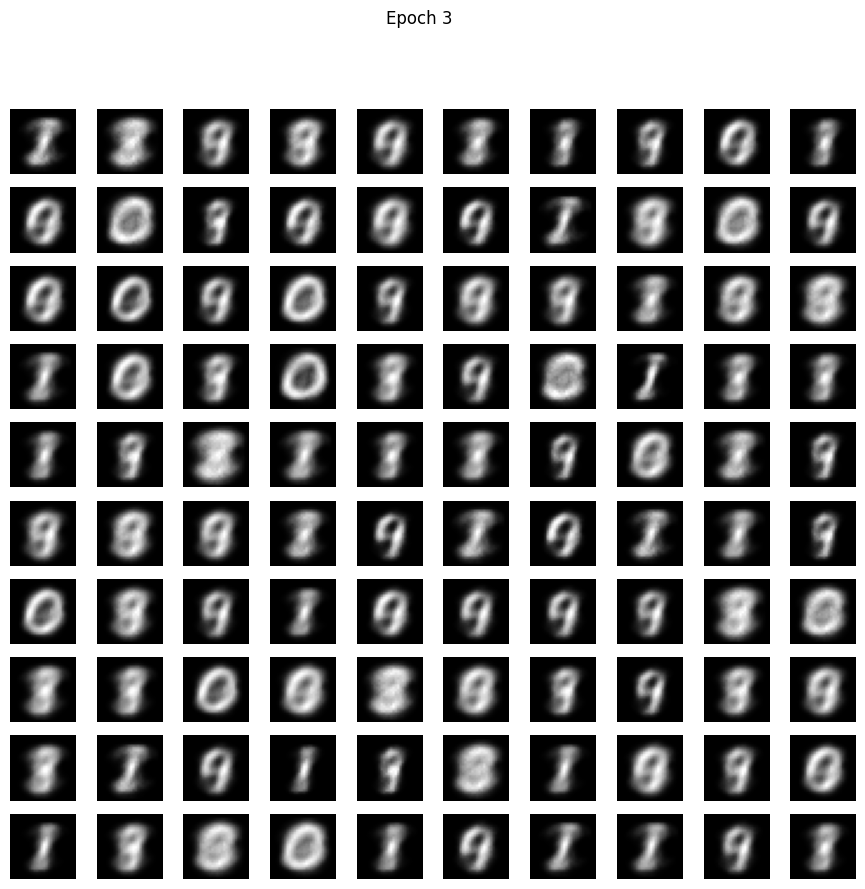

Epoch 4/5 Training ...: 100%|██████████| 468/468 [00:14<00:00, 33.36it/s, Loss: 223.31835357666014]


Epoch 4/5 - Train Loss: 226.91632790850778


Epoch 4/5 Testing ...: 100%|██████████| 79/79 [00:00<00:00, 391.80it/s]


Epoch 4/5 - Test Loss: 221.82541994505291, Recon: 216.4499955961976, KL: 5.375424258316619


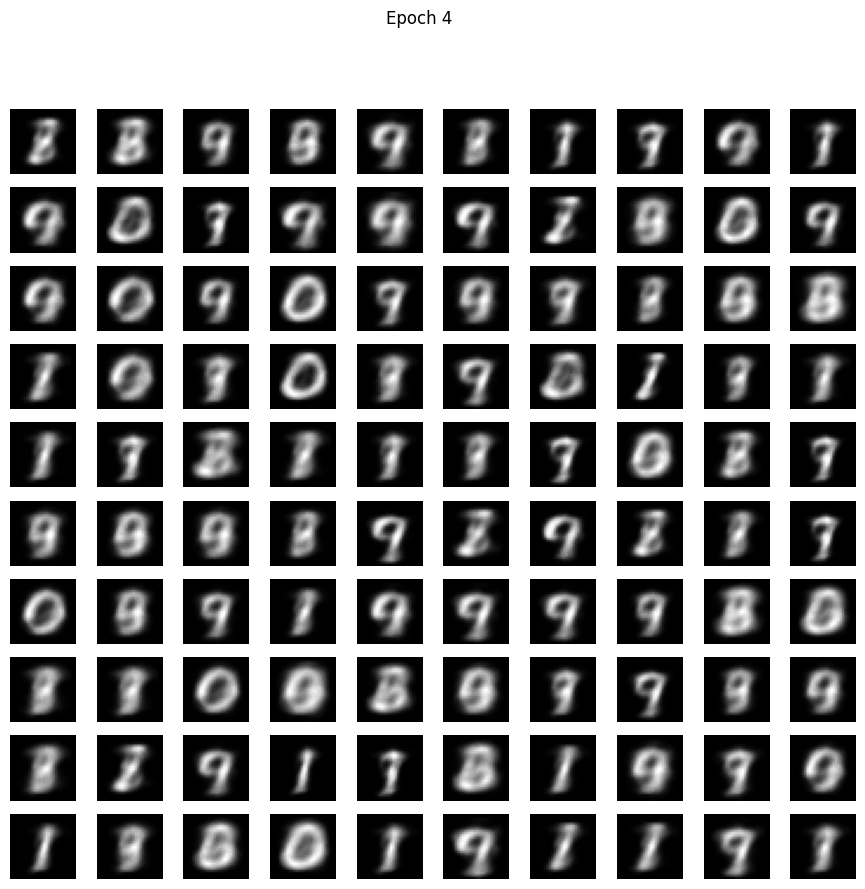

Epoch 5/5 Training ...: 100%|██████████| 468/468 [00:14<00:00, 31.62it/s, Loss: 216.8891162109375] 


Epoch 5/5 - Train Loss: 219.6348361805973


Epoch 5/5 Testing ...: 100%|██████████| 79/79 [00:00<00:00, 401.58it/s]


Epoch 5/5 - Test Loss: 214.48605732978146, Recon: 208.21372908580153, KL: 6.272328859643091


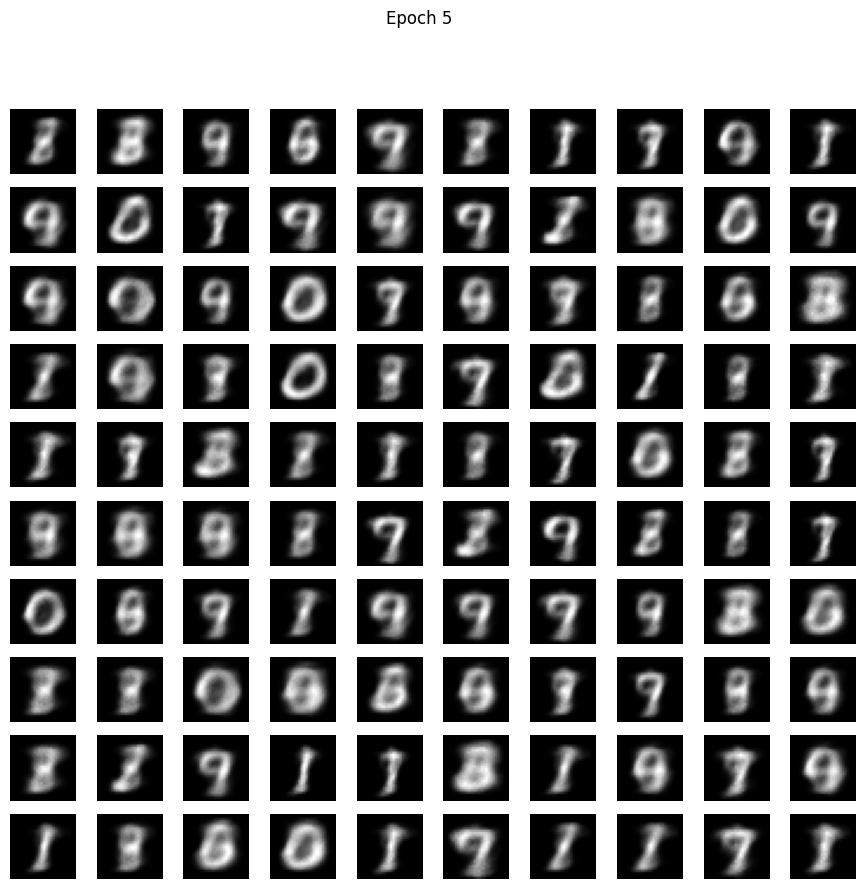

In [16]:
for e in range(1, epochs+1):
    
    train_step_history = []
    
    pbar = tqdm(train_ds.as_numpy_iterator(), total=train_ds.cardinality().numpy(), desc=f"Epoch {e}/{epochs} Training ...", colour="blue")
    for batch in pbar:
        key, _ = jax.random.split(key)
        batch = jnp.array(batch)
        loss, params, optimizer, opt_state = train_step(batch, params, key, optimizer, opt_state)
        train_step_history.append(float(loss))
        pbar.set_postfix_str(f"Loss: {sum(train_step_history[-100:]) / len(train_step_history[-100:])}")
        
    epoch_train_loss = sum(train_step_history)/len(train_step_history)
    print(f"Epoch {e}/{epochs} - Train Loss: {epoch_train_loss}")
    
    test_step_history_total = []
    test_step_history_kl = []
    test_step_history_recon = []
    pbar2 = tqdm(test_ds.as_numpy_iterator(), total=test_ds.cardinality().numpy(), desc=f"Epoch {e}/{epochs} Testing ...", colour="green")
    test_key = jax.random.PRNGKey(0)
    for batch in pbar2:
        test_key = jax.random.split(test_key)[0]
        batch = jnp.array(batch)
        loss = test_step(batch, params, test_key)
        total_loss, recon_loss, kl_loss = loss
        test_step_history_total.append(float(total_loss))
        test_step_history_kl.append(float(kl_loss))
        test_step_history_recon.append(float(recon_loss))

    epoch_test_loss = sum(test_step_history_total)/len(test_step_history_total)
    epoch_test_recon_loss = sum(test_step_history_recon)/len(test_step_history_recon)
    epoch_test_kl_loss = sum(test_step_history_kl)/len(test_step_history_kl)
    
    print(f"Epoch {e}/{epochs} - Test Loss: {epoch_test_loss}, Recon: {epoch_test_recon_loss}, KL: {epoch_test_kl_loss}")
    
    visualize(fixed_noise, params, e)